# Analyze NYC-Flight data

## Agenda

1. [methods to deal with Categorical Variables](#deal)
2. [Flight Dataset](#dataset)
    - 1.1 [Loading the data](#read)
    - 1.2 [Visualizing the data](#visualize) <br><br>
3. [PreProcessing](#process)
    - 3.1 [Fill missing value](#missing)
    - 3.2 [featureEngineering](#fea)  <br><br>
4. [Results ](#result)

## methods to deal with Categorical Variables<a id='deal'>

Categorical Data: Nominal, Ordinal vs Continuous
Features which have some order associated with them are called ordinal features. For example, a feature like economic status, with three categories: low, medium and high, which have an order associated with them. on the other hand feature which doesnot have any order associated with them are called nominal eg. gender (male,female)

There are also continuous features. These are numeric variables that have an infinite number of values between any two values. A continuous variable can be numeric or a date/time.

the challenge is determining how to use this data in the analysis because of the following constraints:

1. Categorical features may have a very large number of levels, known as high cardinality, (for example, cities or URLs), where most of the levels appear in a relatively small number of instances.
2. Many machine learning models, such as regression or SVM, are algebraic. This means that their input must be numerical. To use these models, categories must be transformed into numbers first, before you can apply the learning algorithm on them.
3. While some ML packages or libraries might transform categorical data to numeric automatically based on some default embedding method, many other ML packages don’t support such inputs.
4. For the machine, categorical data doesn’t contain the same context or information that humans can easily associate and understand. For example, when looking at a feature called City with three cities New York, New Jersey and New Delhi, humans can infer that New York is closely related to New Jersey as they are from same country, while New York and New Delhi are much different. But for the model, New York, New Jersey and New Delhi, are just three different levels (possible values) of the same feature City. If you don’t specify the additional contextual information, it will be impossible for the model to differentiate between highly different levels.

Proven methods to deal with Categorical Variables

As discussed above, some ML libraries do not take categorical variables as input. Thus, we convert them into numerical variables. Below are the methods to convert a categorical (string) input to numerical nature:

 a. Replace Values: replacing the categories with the desired numbers. it is most basic method
 
     labels = cat_df_flights['carrier'].astype('category').cat.categories.tolist()
     replace_map_comp = {'carrier' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
     cat_df_flights.replace(replace_map_comp, inplace=True)
     print(cat_df_flights.head())
     
     Tip:in Python, it's a good practice to typecast categorical features to a category dtype because they make the operations
     on such columns much faster than the object dtype. You can do the typecasting by using .astype() method on your columns.
     
     import time
        %timeit cat_df_flights.groupby(['origin','carrier']).count() #DataFrame with object dtype columns
        %timeit cat_df_flights_lc.groupby(['origin','carrier']).count() #DataFrame with category dtype columns
        
 b. Label Encoder: It is used to transform non-numerical labels to numerical labels (or nominal categorical variables). 
       Numerical labels are always between 0 and n_classes-1. 
       
       You can do label encoding via attributes .cat.codes on your DataFrame's column.
       cat_df_flights_lc['carrier'] = cat_df_flights_lc['carrier'].cat.codes
       
       Sometimes, you might just want to encode a bunch of categories within a feature to some numeric value and encode all the 
       other categories to some other numeric value.
       cat_df_flights_specific['US_code'] = np.where(cat_df_flights_specific['carrier'].str.contains('US'), 1, 0)
       
       You can achieve the same label encoding using scikit-learn's LabelEncoder:
       from sklearn.preprocessing import LabelEncoder
       lb_make = LabelEncoder()
       cat_df_flights_sklearn['carrier_code'] = lb_make.fit_transform(cat_df_flights['carrier'])
       
       Label Encoder is good but it has disadvantage that the numerical values can be misinterpreted by the algorithm. Should
       the carrier US (encoded to 8) be given 8x more weight than the carrier AS (encoded to 1) ? To solve this issue there is
       another popular way to encode the categories via something called one-hot encoding.
       
 c. One-Hot encoding
        The basic strategy is to convert each category value into a new column and assign a 1 or 0 (True/False) value to the 
        column. This has the benefit of not weighting a value improperly.
        
        There are many libraries that support one-hot encoding but the simplest one is using pandas' .get_dummies()method.
        cat_df_flights_onehot = pd.get_dummies(cat_df_flights_onehot, columns=['carrier'], prefix = ['carrier'])
        
        scikit-learn also supports one hot encoding via LabelBinarizer and OneHotEncoder.
        from sklearn.preprocessing import LabelBinarizer
        lb = LabelBinarizer()
        lb_results = lb.fit_transform(cat_df_flights_onehot_sklearn['carrier'])
        lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
        result_df = pd.concat([cat_df_flights_onehot_sklearn, lb_results_df], axis=1)
        
        it is not very useful when there are many categories, as that will result in formation of as many new columns, which can
        result in the curse of dimensionality. The concept of the “curse of dimensionality” discusses that in high-dimensional 
        spaces some things just stop working properly.
        
        
 d. Binary Encoding:
         This technique is not as intuitive as the previous ones. In this technique, first the categories are encoded as 
         ordinal, then those integers are converted into binary code, then the digits from that binary string are split into 
         separate columns. This encodes the data in fewer dimensions than one-hot.
         
         You can do binary encoding via a number of ways but the simplest one is using the category_encoders library. You can 
         install category_encoders via pip install category_encoders
         mport category_encoders as ce
         encoder = ce.BinaryEncoder(cols=['carrier'])
         df_binary = encoder.fit_transform(cat_df_flights_ce)
         
         Note that category_encoders is a very useful library for encoding categorical columns. Not only does it support one-
         hot, binary and label encoding, but also other advanced encoding methods like Helmert contrast, polynomial contrast, 
         backward difference, etc.
         
 e. Miscellaneous Feature:
         1. Convert numeric bins to number: 
         Let’s say, bins of a continuous variable “Age” has bins (0-17, 17-25, 26-35 …). 
         We can convert these bins into definite numbers by creating a new feature using mean or mode (most relevant value) 
         of each age bucket. It would comprise of additional weight for levels.
         Then you will split the column on the delimeter - into two columns start and end using split() with a lambda() function
         dummy_df_age = pd.DataFrame({'age': ['0-20', '20-40', '40-60','60-80']})
         def split_mean(x):
            split_list = x.split('-')
            mean = (float(split_list[0])+float(split_list[1]))/2
         return mean
         dummy_df_age['age_mean'] = dummy_df_age['age'].apply(lambda x: split_mean(x))
         
         2. Combine levels: 
         To avoid redundant levels in a categorical variable and to deal with rare levels, we can simply combine the different 
         levels. There are various methods of combining levels. Here are commonly used ones:
            2.1 Using Business Logic: It is one of the most effective method of combining levels. It makes sense also to combine
            similar levels into similar groups based on domain or business experience. For example, we can combine levels of a 
            variable “zip code” at state or district level. 
            2.2 Using frequency or response rate: Combining levels based on business logic is effective but we may always not
            have the domain knowledge. In such cases, we combine levels by considering the frequency distribution or response
            rate.
                2.2.1 To combine levels using their frequency, we first look at the frequency distribution of of each level and 
                combine levels having frequency less than 5% of total observation (5% is standard but you can change it based on
                distribution) into one level and let other level as it is. This is an effective method to deal with rare levels.
                
                cat_df_flights['freq']=cat_df_flights['tailnum'].value_counts()
                cat_df_flights['freq']=cat_df_flights['tailnum'].value_counts().count()
                
                2.2.2 We can also combine levels by considering the response rate of each level. We can simply combine levels 
                having similar response rate into same group


## Flight Dataset<a id='dataset'>

<b>Domain & topic of project</b>
Airline Industry is a system of transportation
Part of Aviation industry
Moving people and goods
Utilizing the airways
One of the only true global businesses Cargo 

Topic of Project-- Analyze NYC-Flight data
Analyse the NYC flight data to understand:
The flight behaviour
Speed
Timing
Best carrier
Best airport
Delay analysis etc

This dataset contains information about all flights that departed from NYC (e.g. EWR, JFK and LGA) in 2013: 336,776 flights in total. 
Total 0.6% of missing values
air_time has 9430 / 2.8% missing values Missing Rejected
arr_time has 8713 / 2.6% missing values Missing
dep_delay has 8255 / 2.5% missing values Missing
dep_time has 8255 / 2.5% missing values

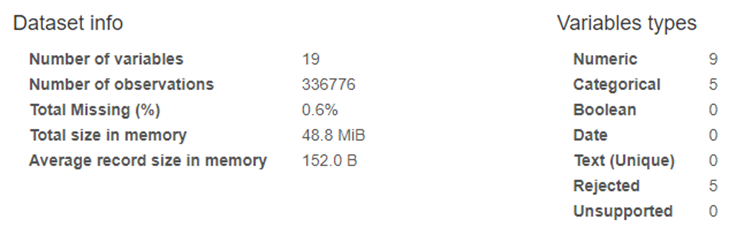

## Loading the data<a id='read'>

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
Your_local_path="C:/Users/Vivek/"

In [31]:
flight_input=pd.read_csv(Your_local_path+'flight_data.csv')

###### create a pandas profiling report

In [4]:
import pandas_profiling
report=pandas_profiling.ProfileReport(flight_input)
#covert profile report as html file
report.to_file("flight_data.html")

###### modify pandas display option and view first 5 rows of data

In [32]:
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
flight_input.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,01-01-2013 05:00
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,01-01-2013 05:00
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,01-01-2013 05:00
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,01-01-2013 05:00
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,01-01-2013 06:00


In [33]:
flight_input.describe()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,flight,air_time,distance,hour,minute
count,336776.0,336776.000000,336776.000000,328521.000000,336776.000000,328521.000000,328063.000000,336776.000000,327346.000000,336776.000000,327346.000000,336776.000000,336776.000000,336776.000000
mean,2013.0,6.548510,15.710787,1349.109947,1344.254840,12.639070,1502.054999,1536.380220,6.895377,1971.923620,150.686460,1039.912604,13.180247,26.230100
std,0.0,3.414457,8.768607,488.281791,467.335756,40.210061,533.264132,497.457142,44.633292,1632.471938,93.688305,733.233033,4.661316,19.300846
min,2013.0,1.000000,1.000000,1.000000,106.000000,-43.000000,1.000000,1.000000,-86.000000,1.000000,20.000000,17.000000,1.000000,0.000000
25%,2013.0,4.000000,8.000000,907.000000,906.000000,-5.000000,1104.000000,1124.000000,-17.000000,553.000000,82.000000,502.000000,9.000000,8.000000
50%,2013.0,7.000000,16.000000,1401.000000,1359.000000,-2.000000,1535.000000,1556.000000,-5.000000,1496.000000,129.000000,872.000000,13.000000,29.000000
75%,2013.0,10.000000,23.000000,1744.000000,1729.000000,11.000000,1940.000000,1945.000000,14.000000,3465.000000,192.000000,1389.000000,17.000000,44.000000
max,2013.0,12.000000,31.000000,2400.000000,2359.000000,1301.000000,2400.000000,2359.000000,1272.000000,8500.000000,695.000000,4983.000000,23.000000,59.000000


In [34]:
flight_input.info()
#The columns with object dtype are the possible categorical features in your dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 19 columns):
year              336776 non-null int64
month             336776 non-null int64
day               336776 non-null int64
dep_time          328521 non-null float64
sched_dep_time    336776 non-null int64
dep_delay         328521 non-null float64
arr_time          328063 non-null float64
sched_arr_time    336776 non-null int64
arr_delay         327346 non-null float64
carrier           336776 non-null object
flight            336776 non-null int64
tailnum           334264 non-null object
origin            336776 non-null object
dest              336776 non-null object
air_time          327346 non-null float64
distance          336776 non-null int64
hour              336776 non-null int64
minute            336776 non-null int64
time_hour         336776 non-null object
dtypes: float64(5), int64(9), object(5)
memory usage: 48.8+ MB


## Visualizing the data<a id='visualize'>

In [35]:
#create a separate DataFrame consisting of only these categorical features
cat_df_flights = flight_input.select_dtypes(include=['object']).copy()
#Let's also check the column-wise distribution of null values:
print(cat_df_flights.isnull().sum())

carrier         0
tailnum      2512
origin          0
dest            0
time_hour       0
dtype: int64


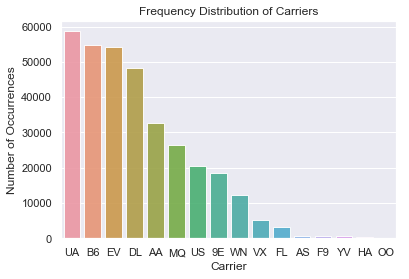

In [36]:
#It seems that only the tailnum column has null values. 
#You can do a mode imputation for those null values. The function fillna() is handy for such operations.
#method .value_counts() returns the frequency distribution of each category in the feature

#print(cat_df_flights['tailnum'].value_counts())

#Then selecting the top category, which is the mode, with the .index attribute.
cat_df_flights = cat_df_flights.fillna(cat_df_flights['tailnum'].value_counts().index[0])

#plot a barplot of the frequency distribution of a categorical feature using the seaborn package
carrier_count = cat_df_flights['carrier'].value_counts()
sns.set(style="darkgrid")
sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
plt.title('Frequency Distribution of Carriers')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Carrier', fontsize=12)
plt.show()

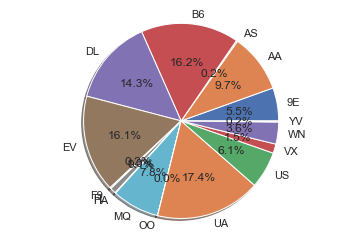

In [37]:
#Similarly, you could plot a pie chart with the matplotlib library to get the same information. 
labels = cat_df_flights['carrier'].astype('category').cat.categories.tolist()
counts = cat_df_flights['carrier'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

## fill missing values in column by meadian in each group of carrier <a id='missing'>

In [38]:
dataframe1=flight_input
grouped_df1=dataframe1.groupby(['carrier'])
grouped_df1

In [39]:
dataframe1.dep_delay=grouped_df1['dep_delay'].transform(lambda x: x.fillna(x.median()))
dataframe1.arr_delay=grouped_df1['arr_delay'].transform(lambda x: x.fillna(x.median()))
dataframe1.tail(10)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
336766,2013,9,30,2240.0,2250,-10.0,2347.0,7,-20.0,B6,2002,N281JB,JFK,BUF,52.0,301,22,50,30-09-2013 22:00
336767,2013,9,30,2241.0,2246,-5.0,2345.0,1,-16.0,B6,486,N346JB,JFK,ROC,47.0,264,22,46,30-09-2013 22:00
336768,2013,9,30,2307.0,2255,12.0,2359.0,2358,1.0,B6,718,N565JB,JFK,BOS,33.0,187,22,55,30-09-2013 22:00
336769,2013,9,30,2349.0,2359,-10.0,325.0,350,-25.0,B6,745,N516JB,JFK,PSE,196.0,1617,23,59,30-09-2013 23:00
336770,2013,9,30,NaN,1842,-1.0,NaN,2019,-1.0,EV,5274,N740EV,LGA,BNA,NaN,764,18,42,30-09-2013 18:00
336771,2013,9,30,NaN,1455,-2.0,NaN,1634,-7.0,9E,3393,NaN,JFK,DCA,NaN,213,14,55,30-09-2013 14:00
336772,2013,9,30,NaN,2200,-2.0,NaN,2312,-7.0,9E,3525,NaN,LGA,SYR,NaN,198,22,0,30-09-2013 22:00
336773,2013,9,30,NaN,1210,-3.0,NaN,1330,-1.0,MQ,3461,N535MQ,LGA,BNA,NaN,764,12,10,30-09-2013 12:00
336774,2013,9,30,NaN,1159,-3.0,NaN,1344,-1.0,MQ,3572,N511MQ,LGA,CLE,NaN,419,11,59,30-09-2013 11:00
336775,2013,9,30,NaN,840,-3.0,NaN,1020,-1.0,MQ,3531,N839MQ,LGA,RDU,NaN,431,8,40,30-09-2013 08:00


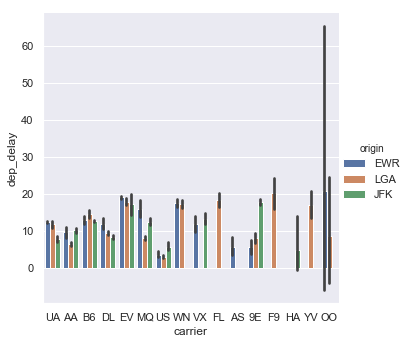

In [40]:
plt.rcParams['figure.figsize'] = (10, 15)
plt.rcParams['font.size'] = 14
sns.catplot(x="carrier", y="dep_delay",hue="origin", data=dataframe1,kind='bar')

ORD    17283
ATL    17215
LAX    16174
BOS    15508
MCO    14082
Name: dest, dtype: int64
EWR    120835
JFK    111279
LGA    104662
Name: origin, dtype: int64


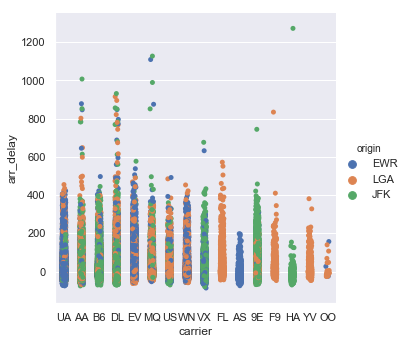

In [41]:
sns.__version__
print(dataframe1['dest'].value_counts().nlargest(5))
#from data ORD has heighest arrival rate
print(dataframe1['origin'].value_counts().nlargest(5))
#from data EWR has heighest departure rate
sns.catplot(x="carrier", y="arr_delay",hue="origin", data=dataframe1)

In [42]:
dataframe1.dep_time=dataframe1.sched_dep_time+dataframe1.dep_delay
dataframe1.arr_time=dataframe1.sched_arr_time+dataframe1.arr_delay
dataframe1.tail(10)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
336766,2013,9,30,2240.0,2250,-10.0,-13.0,7,-20.0,B6,2002,N281JB,JFK,BUF,52.0,301,22,50,30-09-2013 22:00
336767,2013,9,30,2241.0,2246,-5.0,-15.0,1,-16.0,B6,486,N346JB,JFK,ROC,47.0,264,22,46,30-09-2013 22:00
336768,2013,9,30,2267.0,2255,12.0,2359.0,2358,1.0,B6,718,N565JB,JFK,BOS,33.0,187,22,55,30-09-2013 22:00
336769,2013,9,30,2349.0,2359,-10.0,325.0,350,-25.0,B6,745,N516JB,JFK,PSE,196.0,1617,23,59,30-09-2013 23:00
336770,2013,9,30,1841.0,1842,-1.0,2018.0,2019,-1.0,EV,5274,N740EV,LGA,BNA,NaN,764,18,42,30-09-2013 18:00
336771,2013,9,30,1453.0,1455,-2.0,1627.0,1634,-7.0,9E,3393,NaN,JFK,DCA,NaN,213,14,55,30-09-2013 14:00
336772,2013,9,30,2198.0,2200,-2.0,2305.0,2312,-7.0,9E,3525,NaN,LGA,SYR,NaN,198,22,0,30-09-2013 22:00
336773,2013,9,30,1207.0,1210,-3.0,1329.0,1330,-1.0,MQ,3461,N535MQ,LGA,BNA,NaN,764,12,10,30-09-2013 12:00
336774,2013,9,30,1156.0,1159,-3.0,1343.0,1344,-1.0,MQ,3572,N511MQ,LGA,CLE,NaN,419,11,59,30-09-2013 11:00
336775,2013,9,30,837.0,840,-3.0,1019.0,1020,-1.0,MQ,3531,N839MQ,LGA,RDU,NaN,431,8,40,30-09-2013 08:00


## FeatureEnginnering<a id='fea'>

In [43]:
dataframe1['speed']=dataframe1['distance']/dataframe1['air_time']
dataframe1.air_time=dataframe1.groupby(['carrier'])['air_time'].transform(lambda x: x.fillna(x.mean()))
dataframe1['speed'].fillna(dataframe1['distance']/dataframe1['air_time'])

0         6.167401
1         6.237885
2         6.806250
3         8.612022
4         6.568966
5         4.793333
6         6.740506
7         4.320755
8         6.742857
9         5.311594
10        6.899329
11        6.360759
12        7.173913
13        7.105263
14        5.404669
15        4.250000
16        6.608309
17        7.078947
18        5.686567
19        6.959184
20        6.000000
21        4.780952
22        7.138158
23        5.937500
24        6.910828
25        5.172662
26        7.065574
27        6.137143
28        8.780220
29        6.216667
30        6.236842
31        7.163399
32        6.183406
33        5.305263
34        6.144578
35        6.524242
36        8.322917
37        6.704918
38        5.235714
39        4.625000
40        5.813187
41        4.076923
42        5.600806
43        6.597222
44        4.560976
45        7.006849
46        5.813187
47        7.052980
48        4.777778
49        6.666667
50        6.405263
51        6.959752
52        6.

## Results<a id='result'>

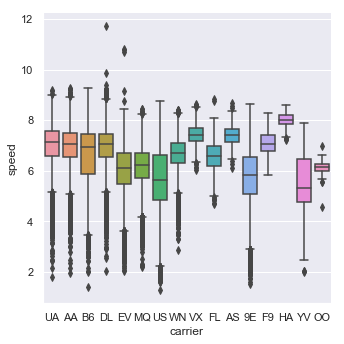

In [44]:
#sns.catplot(x="carrier", y="speed",hue="origin",kind="box", data=dataframe1)
#One of the most common ways to analyze the relationship 
#between a categorical feature and a continuous feature is to plot a boxplot. 
sns.catplot(x="carrier", y="speed",kind="box", data=dataframe1)
#from plot it is clear that DL and EV has reached the heighest spped once, similarily B6 and US has reached the lowest speed once

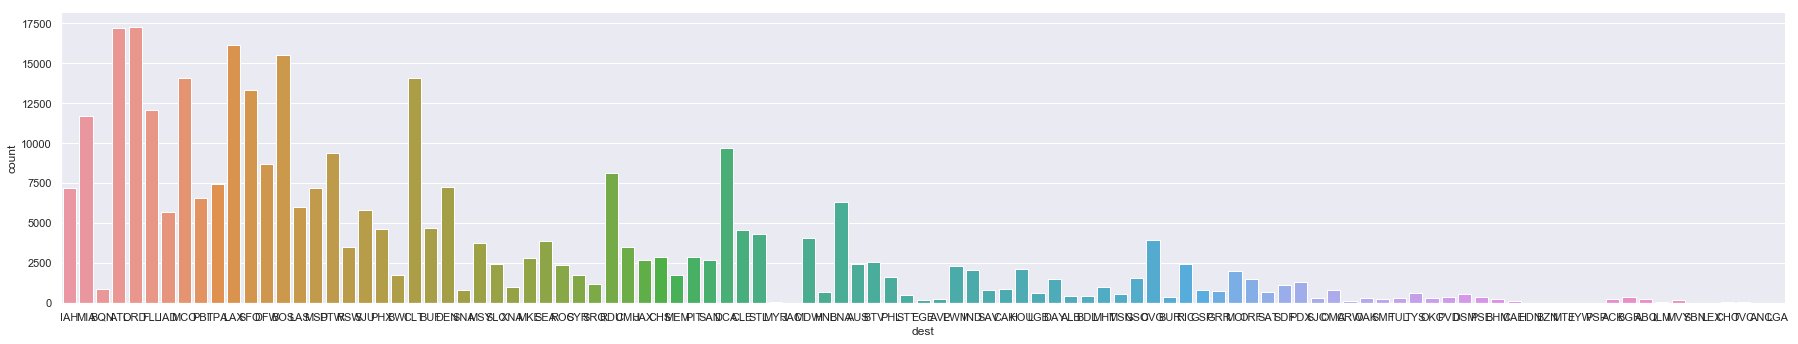

In [20]:
sns.catplot(x="dest", kind="count",aspect=5, data=dataframe1,col_order="Ascending")

###### find correlation between columns

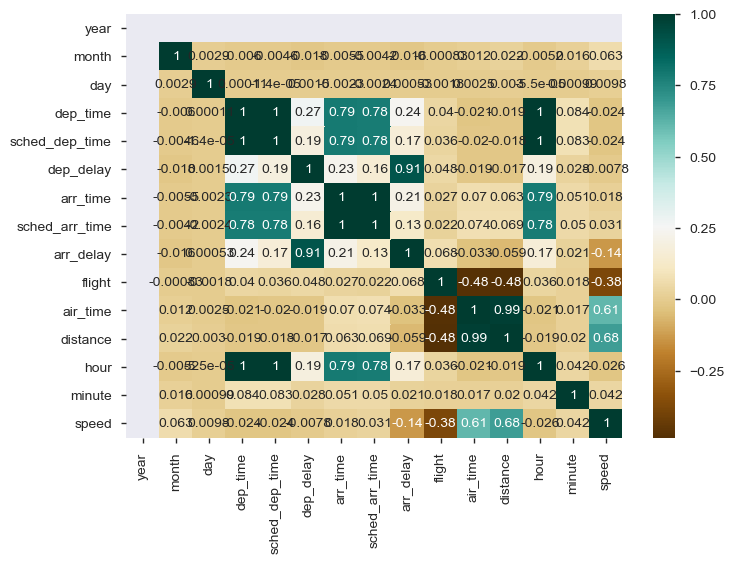

In [16]:
#to find which feature is strongly correlated to other feature
figsize=(25,25)
sns.heatmap(flight_input.corr(),cmap="BrBG",annot=True)

In [73]:
dataframe1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 20 columns):
year              336776 non-null int64
month             336776 non-null int64
day               336776 non-null int64
dep_time          336776 non-null float64
sched_dep_time    336776 non-null int64
dep_delay         336776 non-null float64
arr_time          336776 non-null float64
sched_arr_time    336776 non-null int64
arr_delay         336776 non-null float64
carrier           336776 non-null object
flight            336776 non-null int64
tailnum           334264 non-null object
origin            336776 non-null object
dest              336776 non-null object
air_time          336776 non-null float64
distance          336776 non-null int64
hour              336776 non-null int64
minute            336776 non-null int64
time_hour         336776 non-null object
speed             336776 non-null float64
dtypes: float64(6), int64(9), object(5)
memory usage: 51.4+ MB


In [ ]:
#Let's check the column-wise distribution of null values:
print(cat_df_flights.isnull().sum())

In [39]:
df1=dataframe1.where(dataframe1['dep_delay']>=0)
df2=df1.groupby(['carrier']).mean()
df2.sort_values(by='dep_delay', ascending = False)
#based on results OO,YV,EV,9E are top late departure carrier, whereas UA,AS,VX,US are less late departure

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,flight,air_time,distance,hour,minute
carrier,,,,,,,,,,,,,,
OO,2013.0,8.111111,24.111111,1703.111111,1645.111111,58.000000,1878.888889,1813.222222,65.666667,5489.888889,97.888889,571.333333,16.222222,22.888889
YV,2013.0,6.717131,16.306773,1662.382470,1613.227092,49.155378,1822.908367,1774.960159,47.948207,3356.621514,62.556000,351.653386,15.880478,25.179283
EV,2013.0,6.307928,15.792322,1499.708646,1452.745947,46.962699,1675.172635,1631.340592,43.832043,4595.938705,91.057734,567.538471,14.243770,28.368981
9E,2013.0,6.639387,15.392959,1606.880099,1561.995453,44.884645,1800.422447,1764.640816,35.781632,3528.895687,90.232164,557.607690,15.335022,28.493245
F9,2013.0,6.835052,15.059278,1522.692010,1483.018041,39.673969,1753.644330,1713.677835,39.966495,670.247423,225.973958,1620.000000,14.541237,28.894330
MQ,2013.0,6.559113,15.765581,1504.527308,1465.898586,38.628721,1683.832084,1643.518098,40.313986,3830.255622,90.778114,569.358642,14.378347,28.063932
HA,2013.0,5.325301,14.301205,996.433735,959.156627,37.277108,1526.397590,1505.000000,21.397590,51.000000,626.192771,4983.000000,9.566265,2.530120
FL,2013.0,6.550834,16.065089,1461.004841,1424.641743,36.363098,1679.795051,1641.476062,38.318989,524.349112,101.878378,673.230231,14.002152,24.426573
B6,2013.0,6.346822,15.807862,1569.416071,1534.176901,35.239171,1594.083495,1561.566957,32.516538,652.670025,157.312839,1118.725028,15.036503,30.526572


In [37]:
df3=dataframe1.where(dataframe1['arr_delay']>=0)
df4=df3.groupby(['carrier']).mean()
df4.sort_values(by='arr_delay', ascending = False)
#based on results OO,YV,9E,EV are late arrival carrier, whereas US,AS,HA,UA are less late arrival carrier 

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,flight,air_time,distance,hour,minute
carrier,,,,,,,,,,,,,,
OO,2013.0,7.900000,22.200000,1715.900000,1665.700000,50.200000,1881.400000,1820.800000,60.600000,5588.600000,85.400000,497.200000,16.500000,15.700000
YV,2013.0,6.655303,16.196970,1642.306818,1597.920455,44.386364,1806.393939,1756.473485,49.920455,3392.549242,62.518939,342.537879,15.738636,24.056818
9E,2013.0,6.544289,15.364948,1569.145105,1523.259178,45.885927,1771.137092,1723.493881,47.643211,3559.658945,90.895396,543.724505,14.946387,28.620484
EV,2013.0,6.276448,15.761400,1475.261064,1431.499427,43.761637,1656.867787,1610.128297,46.739490,4581.085189,93.874669,571.380225,14.036148,27.884635
F9,2013.0,6.606280,15.166667,1491.573671,1457.400966,34.172705,1738.463768,1693.355072,45.108696,695.318841,233.426829,1620.000000,14.277778,29.623188
VX,2013.0,7.354348,15.476087,1421.102717,1384.833152,36.269565,1757.613043,1716.005978,41.607065,227.094565,344.689130,2498.982065,13.568478,27.985326
WN,2013.0,6.985717,15.819201,1413.783222,1375.837100,37.946122,1604.515458,1565.440246,39.075212,1428.533719,153.484542,1011.155487,13.479298,27.907250
B6,2013.0,6.420216,15.775912,1514.506053,1482.488241,32.017811,1545.521744,1507.022702,38.499042,657.882739,157.537355,1087.277440,14.523252,30.162992
FL,2013.0,6.298682,15.738409,1415.002928,1383.733041,31.269888,1637.239141,1599.025866,38.213275,514.055637,103.917515,674.362128,13.600293,23.703758


In [54]:
df5=dataframe1.where(dataframe1['dep_delay']>=0)
df5.groupby(['origin']).size().reset_index(name='count')
df6=df5.groupby(['origin']).mean()
df6.sort_values(by='dep_delay', ascending = False)
#based on results JFK is best airport for timely departure

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,flight,air_time,distance,hour,minute
origin,,,,,,,,,,,,,,
LGA,2013.0,6.714219,15.851045,1454.756606,1418.557677,36.198929,1658.609652,1626.196852,32.412800,2081.899845,121.832897,815.924103,13.930942,25.463484
EWR,2013.0,6.430140,15.766696,1466.758012,1431.833005,34.925008,1660.833345,1631.258539,29.574805,2316.257316,159.549592,1114.834704,14.038643,27.968681
JFK,2013.0,6.496307,15.789593,1548.720037,1515.635440,33.084597,1681.062088,1653.622303,27.439785,1331.516893,180.227224,1292.016634,14.873094,28.326037


In [66]:
df7=dataframe1.where(dataframe1['arr_delay']>=0)
df8=df7.groupby(['dest']).size().reset_index(name='count')
df8[df8['count']>1000].sort_values([('count')], ascending=False).head(100)
df7['arr_count']=df8['count']
df9=df7[df7['arr_count']>1000].groupby(['dest']).mean()
df9.sort_values(by='arr_delay', ascending = False)
#based on result PHX is best airport for timely arrival

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,flight,air_time,distance,hour,minute,arr_count
dest,,,,,,,,,,,,,,,
LAX,2013.0,1.0,1.0,702.00,700.00,2.0,1058.000000,1014.000000,44.000000,671.000000,381.000000,2475.000000,7.000000,0.000000,2979.000000
DFW,2013.0,1.0,1.0,670.75,673.75,-3.0,1013.000000,982.500000,30.500000,1054.000000,249.250000,1384.750000,6.500000,23.750000,1644.000000
XNA,2013.0,1.0,1.0,696.00,705.00,-9.0,967.000000,940.000000,27.000000,4534.000000,233.000000,1147.000000,7.000000,5.000000,2882.000000
DTW,2013.0,1.0,1.0,602.00,605.00,-3.0,821.000000,805.000000,16.000000,4401.000000,105.000000,502.000000,6.000000,5.000000,1239.000000
SFO,2013.0,1.0,1.0,611.00,600.00,11.0,945.000000,931.000000,14.000000,303.000000,366.000000,2586.000000,6.000000,0.000000,1738.000000
ORD,2013.0,1.0,1.0,655.00,657.00,-2.0,821.666667,809.333333,12.333333,848.333333,149.666667,723.666667,6.333333,23.666667,1166.333333
MSY,2013.0,1.0,1.0,652.00,655.00,-3.0,932.000000,921.000000,11.000000,117.000000,191.000000,1182.000000,6.000000,55.000000,5768.000000
BUF,2013.0,1.0,1.0,645.00,647.00,-2.0,815.000000,810.000000,5.000000,102.000000,63.000000,301.000000,6.000000,47.000000,2207.000000
IAH,2013.0,1.0,1.0,675.50,679.50,-4.0,987.000000,985.000000,2.000000,484.500000,233.500000,1416.000000,6.500000,29.500000,2431.500000


In [75]:
best_speed = dataframe1.groupby(['carrier']).agg({'speed':[np.size,np.mean]})
best_speed[best_speed[('speed', 'size')]>20000].sort_values([('speed', 'mean')], ascending=False).head(15)
#best of result UA has best speed

speed          
            size      mean
carrier                   
UA       58665.0  7.007556
DL       48110.0  6.969613
AA       32729.0  6.945489
B6       54635.0  6.663519
MQ       26397.0  6.136761
EV       54173.0  6.061766
US       20536.0  5.637514

In [93]:
noofflight=dataframe1.groupby(['dest']).size().reset_index(name='count')
noofflight.sort_values(['count'],ascending=False).head(100)
#based on results ORD has maximum number of flight

,dest,count
69,ORD,17283
4,ATL,17215
49,LAX,16174
11,BOS,15508
54,MCO,14082
23,CLT,14064
90,SFO,13331
35,FLL,12055
58,MIA,11728
28,DCA,9705


In [171]:
pivoted=df3.pivot_table(index=['origin','carrier'],columns='dest',values='dep_time',fill_value=0)
pivoted.head(100)

dest                    ABQ          ACK          ALB       ANC          ATL  \
origin carrier                                                                 
EWR    9E          0.000000     0.000000     0.000000     0.000   896.750000   
       AA          0.000000     0.000000     0.000000     0.000     0.000000   
       AS          0.000000     0.000000     0.000000     0.000     0.000000   
       B6          0.000000     0.000000     0.000000     0.000     0.000000   
       DL          0.000000     0.000000     0.000000     0.000  1252.431652   
       EV          0.000000     0.000000  1657.890661     0.000  1405.278661   
       MQ          0.000000     0.000000     0.000000     0.000     0.000000   
       OO          0.000000     0.000000     0.000000     0.000     0.000000   
       UA          0.000000     0.000000     0.000000  1635.375  1240.834951   
       US          0.000000     0.000000     0.000000     0.000     0.000000   
       VX          0.000000     0.000000     0.000000     0.000     0.000000   
       WN          0.000000     0.000000     0.000000     0.000     0.000000   
JFK    9E          0.000000     0.000000     0.000000     0.000   680.418182   
       AA          0.000000     0.000000     0.000000     0.000     0.000000   
       B6       2005.732283  1032.664151     0.000000     0.000     0.000000   
       DL          0.000000     0.000000     0.000000     0.000  1310.017609   
       EV          0.000000     0.000000     0.000000     0.000   904.000000   
       HA          0.000000     0.000000     0.000000     0.000     0.000000   
       MQ          0.000000     0.000000     0.000000     0.000     0.000000   
       UA          0.000000     0.000000     0.000000     0.000     0.000000   
       US          0.000000     0.000000     0.000000     0.000     0.000000   
       VX          0.000000     0.000000     0.000000     0.000     0.000000   
LGA    9E          0.000000     0.000000     0.000000     0.000     0.000000   
       AA          0.000000     0.000000     0.000000     0.000     0.000000   
       B6          0.000000     0.000000     0.000000     0.000     0.000000   
       DL          0.000000     0.000000     0.000000     0.000  1316.828644   
       EV          0.000000     0.000000     0.000000     0.000  1500.000000   
       F9          0.000000     0.000000     0.000000     0.000     0.000000   
       FL          0.000000     0.000000     0.000000     0.000  1369.160462   
       MQ          0.000000     0.000000     0.000000     0.000  1291.275194   
       OO          0.000000     0.000000     0.000000     0.000     0.000000   
       UA          0.000000     0.000000     0.000000     0.000     0.000000   
       US          0.000000     0.000000     0.000000     0.000     0.000000   
       WN          0.000000     0.000000     0.000000     0.000   620.593220   
       YV          0.000000     0.000000     0.000000     0.000     0.000000   

dest                    AUS          AVL          BDL          BGR  \
origin carrier                                                       
EWR    9E          0.000000     0.000000     0.000000     0.000000   
       AA          0.000000     0.000000     0.000000     0.000000   
       AS          0.000000     0.000000     0.000000     0.000000   
       B6          0.000000     0.000000     0.000000     0.000000   
       DL          0.000000     0.000000     0.000000     0.000000   
       EV          0.000000  1236.339623  1541.829885     0.000000   
       MQ          0.000000     0.000000     0.000000     0.000000   
       OO          0.000000     0.000000     0.000000     0.000000   
       UA       1632.671642     0.000000  1982.500000     0.000000   
       US          0.000000     0.000000     0.000000     0.000000   
       VX          0.000000     0.000000     0.000000     0.000000   
       WN       1000.302013     0.000000     0.000000     0.000000   
JFK    9E       1694.000000     0.000000     0.000000     0

In [102]:
dataframe1.where(dataframe1['distance']>4500).sort_values([('distance')], ascending=False).head(400)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,speed
162,2013.0,1.0,1.0,897.0,900.0,-3.0,1516.0,1530.0,-14.0,HA,51.0,N380HA,JFK,HNL,659.000000,4983.0,9.0,0.0,01-01-2013 09:00,7.561457
259909,2013.0,7.0,11.0,991.0,1000.0,-9.0,1426.0,1430.0,-4.0,HA,51.0,N386HA,JFK,HNL,615.000000,4983.0,10.0,0.0,11-07-2013 10:00,8.102439
141982,2013.0,3.0,7.0,895.0,900.0,-5.0,1511.0,1540.0,-29.0,HA,51.0,N380HA,JFK,HNL,650.000000,4983.0,9.0,0.0,07-03-2013 09:00,7.666154
260946,2013.0,7.0,12.0,997.0,1000.0,-3.0,1418.0,1430.0,-12.0,HA,51.0,N384HA,JFK,HNL,598.000000,4983.0,10.0,0.0,12-07-2013 10:00,8.332776
141043,2013.0,3.0,6.0,895.0,900.0,-5.0,1499.0,1540.0,-41.0,HA,51.0,N385HA,JFK,HNL,640.000000,4983.0,9.0,0.0,06-03-2013 09:00,7.785938
140076,2013.0,3.0,5.0,892.0,900.0,-8.0,1509.0,1540.0,-31.0,HA,51.0,N384HA,JFK,HNL,654.000000,4983.0,9.0,0.0,05-03-2013 09:00,7.619266
261903,2013.0,7.0,13.0,998.0,1000.0,-2.0,1440.0,1430.0,10.0,HA,51.0,N381HA,JFK,HNL,605.000000,4983.0,10.0,0.0,13-07-2013 10:00,8.236364
139134,2013.0,3.0,4.0,919.0,900.0,19.0,1541.0,1540.0,1.0,HA,51.0,N386HA,JFK,HNL,649.000000,4983.0,9.0,0.0,04-03-2013 09:00,7.677966
138148,2013.0,3.0,3.0,901.0,900.0,1.0,1519.0,1540.0,-21.0,HA,51.0,N389HA,JFK,HNL,654.000000,4983.0,9.0,0.0,03-03-2013 09:00,7.619266
262702,2013.0,7.0,14.0,994.0,1000.0,-6.0,1415.0,1430.0,-15.0,HA,51.0,N389HA,JFK,HNL,604.000000,4983.0,10.0,0.0,14-07-2013 10:00,8.250000
